# Xinwucwp test networks vs fda

In [1]:
!git clone https://github.com/xinwucwp/faultSeg.git

Cloning into 'faultSeg'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 786 (delta 65), reused 79 (delta 37), pack-reused 676
Receiving objects: 100% (786/786), 1.83 GiB | 37.14 MiB/s, done.
Resolving deltas: 100% (361/361), done.
Checking out files: 100% (100/100), done.


In [2]:
from keras.models import load_model
from faultSeg.unet3 import *


# load json and create model 
json_file = open('/content/faultSeg/model/model3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/Faults/3D_2DSynt_Segmentation/models/Копия pretrained_model.hdf5")

# loaded_model = load_model('/content/drive/My Drive/Faults/3D_2DSynt_Segmentation/models/Копия fseg-65.hdf5',
#                                        custom_objects={'cross_entropy_balanced': cross_entropy_balanced})
print("Loaded model from disk")

# training image dimensions
n1, n2, n3 = 128, 128, 128

Loaded model from disk


In [7]:
# MODEL_PATH = '/content/drive/My Drive/Faults/3D_2DSynt_Segmentation/models/base_model_synt_date0610augs.h5'
# MODEL_PATH = '/content/drive/My Drive/Faults/3D_2DSynt_Segmentation/models/base_model_synt_date0710augs512tversky.h5'
MODEL_PATH = '/content/drive/My Drive/Faults/3D_2DSynt_Segmentation/models/base_model_synt_date0810augs512_dilate.h5'

In [8]:
#@title load my model
import json
from time import time
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, auc
from sklearn.metrics import average_precision_score, precision_recall_curve
from tqdm import tqdm


def _to_tensor(x, dtype):
    ''' Convert the input `x` to a tensor of type `dtype`. '''
    x = tf.convert_to_tensor(x)
    if x.dtype != dtype:
        x = tf.cast(x, dtype)
    return x

def cross_entropy_balanced(y_true, y_pred):
    ''' 
    tf.nn.sigmoid_cross_entropy_with_logits expects y_pred is logits, 
    Keras expects probabilities. transform y_pred back to logits
    '''
    _epsilon = _to_tensor(K.epsilon(), y_pred.dtype.base_dtype)
    y_pred   = tf.clip_by_value(y_pred, _epsilon, 1 - _epsilon)
    y_pred   = tf.math.log(y_pred/ (1 - y_pred))
    y_true = tf.cast(y_true, tf.float32)
    count_neg = tf.math.reduce_sum(1. - y_true)
    count_pos = tf.math.reduce_sum(y_true)
    beta = count_neg / (count_neg + count_pos)
    pos_weight = beta / (1 - beta)
    cost = tf.nn.weighted_cross_entropy_with_logits(
            logits=y_pred, labels=y_true, pos_weight=pos_weight)
    cost = tf.math.reduce_mean(cost * (1 - beta))
    return tf.where(tf.equal(count_pos, 0.0), 0.0, cost)



def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)



model = tf.keras.models.load_model(MODEL_PATH,
                                   custom_objects={'cross_entropy_balanced': cross_entropy_balanced, 'dice_coef': dice_coef})

input, output = model.input, model.output


print('Model info":')
print(f'Input: {input}')
print(f'Output: {output}')

Model info":
Input: Tensor("input_1_1:0", shape=(None, 128, 128, 128, 1), dtype=float32)
Output: Tensor("conv3d_14/Sigmoid:0", shape=(None, 128, 128, 128, 1), dtype=float32)


In [17]:
# set gaussian weights in the overlap bounaries
def getMask(os):
    sc = np.zeros((n1,n2,n3),dtype=np.single)
    sc = sc+1
    sp = np.zeros((os),dtype=np.single)
    sig = os/4
    sig = 0.5/(sig*sig)
    for ks in range(os):
        ds = ks-os+1
        sp[ks] = np.exp(-ds*ds*sig)
    for k1 in range(os):
        for k2 in range(n2):
            for k3 in range(n3):
                sc[k1][k2][k3]=sp[k1]
                sc[n1-k1-1][k2][k3]=sp[k1]
    for k1 in range(n1):
        for k2 in range(os):
            for k3 in range(n3):
                sc[k1][k2][k3]=sp[k2]
                sc[k1][n3-k2-1][k3]=sp[k2]
    for k1 in range(n1):
        for k2 in range(n2):
            for k3 in range(os):
                sc[k1][k2][k3]=sp[k3]
                sc[k1][k2][n3-k3-1]=sp[k3]
    return sc

In [19]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#a 3d array of gx[m1][m2][m3], please make sure the dimensions are correct!!!
#we strongly suggest to gain the seismic image before input it to the faultSeg!!!
# gx,m1,m2,m3 = np.fromfile("/content/drive/My Drive/Faults/3D_2DSynt_Segmentation/predict/Копия gxl.dat",dtype=np.single),512,384,128

m1,m2,m3 = data_sgy.shape
gx = data_sgy

os = 12 #overlap width
c1 = np.round((m1+os)/(n1-os)+0.5)
c2 = np.round((m2+os)/(n2-os)+0.5)
c3 = np.round((m3+os)/(n3-os)+0.5)
c1 = int(c1)
c2 = int(c2)
c3 = int(c3)
p1 = (n1-os)*c1+os
p2 = (n2-os)*c2+os
p3 = (n3-os)*c3+os
gx = np.reshape(gx,(m1,m2,m3))
gp = np.zeros((p1,p2,p3),dtype=np.single)
gy = np.zeros((p1,p2,p3),dtype=np.single)
mk = np.zeros((p1,p2,p3),dtype=np.single)
gs = np.zeros((1,n1,n2,n3,1),dtype=np.single)
gp[0:m1,0:m2,0:m3]=gx
sc = getMask(os)

# for Копия pretrained_model.hdf5
def scale_min_max(gs):
    gs = gs-np.min(gs)
    gs = gs/np.max(gs)
    gs = gs*255
    return gs

# for new zuwu models
def scale_std_mean(gs):
    m = np.mean(gs)
    std = np.mean(gs)
    gs = (gs - m) / std
    gs = np.transpose(gs)
    return np.reshape(gs,(1,n1,n2,n3,1))

# form my model
def scale_volume(x):
    x = (x - x.min()) / (x.max() - x.min())
    return x


for k1 in range(c1):
    for k2 in range(c2):
        for k3 in range(c3):
            b1 = k1*n1-k1*os
            e1 = b1+n1
            b2 = k2*n2-k2*os
            e2 = b2+n2
            b3 = k3*n3-k3*os
            e3 = b3+n3
            gs[0,:,:,:,0]=gp[b1:e1,b2:e2,b3:e3]
            
            gs = scale_volume(gs)
            Y = model.predict(gs,verbose=1)


            # gs = scale_std_mean(gs)


            # gs = scale_min_max(gs)
            # Y = loaded_model.predict(gs,verbose=1)

            Y = np.array(Y)
            gy[b1:e1,b2:e2,b3:e3]= gy[b1:e1,b2:e2,b3:e3]+Y[0,:,:,:,0]*sc
            mk[b1:e1,b2:e2,b3:e3]= mk[b1:e1,b2:e2,b3:e3]+sc
gy = gy/mk
gy = gy[0:m1,0:m2,0:m3]
gy.tofile("fp.dat",format="%4")

1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


1/1 [==============================] - 0s 72ms/step


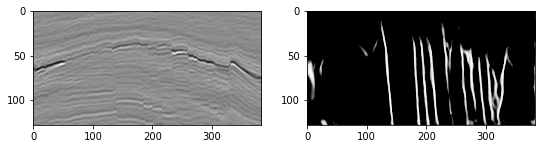

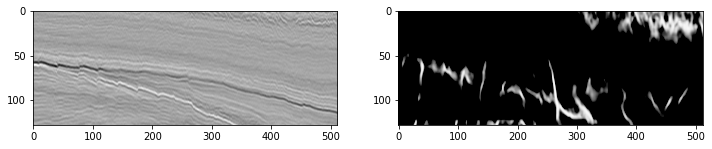

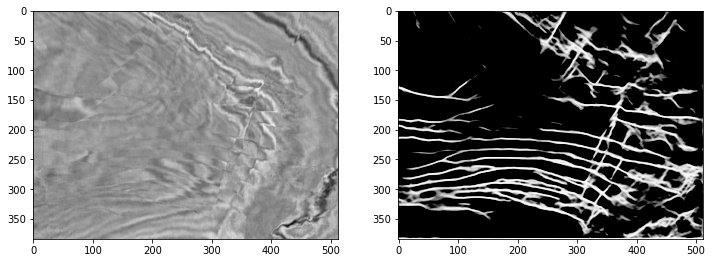

In [10]:
from matplotlib.colors import Normalize
from PIL import Image
gx,m1,m2,m3 = np.fromfile("/content/drive/My Drive/Faults/3D_2DSynt_Segmentation/predict/Копия gxl.dat",dtype=np.single),512,384,128
gx = np.reshape(gx,(m1,m2,m3))
gy = np.reshape(gy,(m1,m2,m3))

k1,k2,k3 = 29,29,99
gx1 = np.transpose(gx[k1,:,:])
gy1 = np.transpose(gy[k1,:,:])
gx2 = np.transpose(gx[:,k2,:])
gy2 = np.transpose(gy[:,k2,:])
gx3 = np.transpose(gx[:,:,k3])
gy3 = np.transpose(gy[:,:,k3])

#xline slice
fig = plt.figure(figsize=(9,9))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx1,aspect=1.5,cmap=plt.cm.gray)
p2 = plt.subplot(1,2,2)
p2.imshow(gy1,aspect=1.5,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)

#inline slice
fig = plt.figure(figsize=(12,12))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx2,aspect=1.5,cmap=plt.cm.gray)
p2 = plt.subplot(1,2,2)
p2.imshow(gy2,aspect=1.5,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)

#time slice
fig = plt.figure(figsize=(12,12))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx3,cmap=plt.cm.gray)
p2 = plt.subplot(1,2,2)
p2.imshow(gy3,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)

In [20]:
#@title slice viewer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from ipywidgets.widgets import *
from ipywidgets import widgets
from IPython.display import display

plt.style.use('seaborn-white')



class SliceViewer():

    '''
        Arguments: 
            traces_volume - np.array with shape (nx, ny, nz)
            labels_volume - np.array with shape (nx, ny, nz)
            figsize - tuple, plot size

    '''

    def __init__(self, traces_volume, labels_volume,
                 figsize=(7, 7), tr_cmap='gray', lb_cmap='Greens'):

        assert traces_volume.shape == labels_volume.shape, 'Shapes must be equal'

        self.tr_volume = traces_volume
        self.lb_volume = labels_volume
        self.figsize = figsize
        self.tr_cmap = tr_cmap
        self.lb_cmap = lb_cmap

        self.nx, self.ny, self.nz = self.tr_volume.shape

        self.widget = self.__create_widget()


    def __create_widget(self):

        x_slider = IntSlider(min=0, max=self.nx - 1, step=1, value=int(self.nx/2))
        y_slider = IntSlider(min=0, max=self.ny - 1, step=1, value=int(self.ny/2))
        z_slider = IntSlider(min=0, max=self.nz - 1, step=1, value=int(self.nz/2))
        alpha = IntSlider(min=0, max=100, step=5, value=70)
        selector = ['x','y','z']
        w = interact(self.__show, x=x_slider, y=y_slider,
                     z=z_slider, alpha=alpha, dim=selector)

        return w

    
    def __get_slice(self, x, y, z, dim):

        if dim == 'x':
            tr = self.tr_volume[x, :, :]
            lb = self.lb_volume[x, :, :]
        elif dim == 'y':
            tr = self.tr_volume[:, y, :]
            lb = self.lb_volume[:, y, :]
        else:
            tr = self.tr_volume[:, :, z]
            lb = self.lb_volume[:, :, z]
        
        return tr, lb


    def __set_labels(self, ax, dim):

        if dim == 'x':
            ax.set_xlabel('y')
            ax.set_ylabel('z')
        elif dim == 'y':
            ax.set_xlabel('x')
            ax.set_ylabel('z')
        else:
            ax.set_xlabel('y')
            ax.set_ylabel('x')

    
    def __show(self, x, y, z, alpha, dim):

        tr, lb = self.__get_slice(x, y, z, dim)

        fig, ax = plt.subplots(figsize=self.figsize)
        plt.imshow(tr.T, cmap=self.tr_cmap, aspect='equal')
        plt.imshow(lb.T, alpha=(100-alpha)/100, aspect='equal', cmap=self.lb_cmap, vmin=0.4, vmax=1.0)
        self.__set_labels(ax, dim)
        plt.grid()
        plt.show()
        display()

        ax.set_xlabel('x')
        ax.set_ylabel('z')


In [12]:
SliceViewer(gx, gy, figsize=(22, 22), tr_cmap='seismic')

interactive(children=(IntSlider(value=256, description='x', max=511), IntSlider(value=192, description='y', ma…

In [26]:
to_show = gy

In [21]:
gym = gy.copy()

In [27]:
to_show = gym > 0.8
SliceViewer(gx, to_show, figsize=(22, 22), tr_cmap='seismic')

interactive(children=(IntSlider(value=331, description='x', max=661), IntSlider(value=503, description='y', ma…

In [ ]:
gyo = gy.copy()

In [ ]:
tshow = gyo > 0.8
SliceViewer(gx, tshow, figsize=(22, 22), tr_cmap='seismic')

# Predict f3

In [13]:
!pip install segyio
!pip install obspy

     |████████████████████████████████| 92kB 5.0MB/s 
     |████████████████████████████████| 24.7MB 132kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for obspy: filename=obspy-1.2.2-cp36-cp36m-linux_x86_64.whl size=21667886 sha256=c6cd6c2b0cb7247460e6c82b3abf5960dace5bc531f49888bbde83a51540edfc
  Stored in directory: /root/.cache/pip/wheels/94/e0/86/44fd4cea7661f42431c8f6d030f2758ff275cccffcbe8fa2b8
Successfully built obspy


In [ ]:
# MODEL_PATH = '/content/drive/My Drive/Faults/3D_2DSynt_Segmentation/models/base_model_synt_date0510.h5' # 07
MODEL_PATH = '/content/drive/My Drive/Faults/3D_2DSynt_Segmentation/models/base_model_synt_date0610augs.h5'

In [ ]:
import tensorflow as tf

def cross_entropy_balanced(y_true, y_pred):
    # Note: tf.nn.sigmoid_cross_entropy_with_logits expects y_pred is logits, 
    # Keras expects probabilities.
    # transform y_pred back to logits
    _epsilon = _to_tensor(K.epsilon(), y_pred.dtype.base_dtype)
    y_pred   = tf.clip_by_value(y_pred, _epsilon, 1 - _epsilon)
    y_pred   = tf.log(y_pred/ (1 - y_pred))

    y_true = tf.cast(y_true, tf.float32)

    count_neg = tf.reduce_sum(1. - y_true)
    count_pos = tf.reduce_sum(y_true)

    beta = count_neg / (count_neg + count_pos)

    pos_weight = beta / (1 - beta)

    cost = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, targets=y_true, pos_weight=pos_weight)

    cost = tf.reduce_mean(cost * (1 - beta))

    return tf.where(tf.equal(count_pos, 0.0), 0.0, cost)

model = tf.keras.models.load_model(MODEL_PATH,
                                   custom_objects={'cross_entropy_balanced': cross_entropy_balanced})
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 128, 128 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 128, 128, 128 6928        conv3d[0][0]                     
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 64, 64, 64, 1 0           conv3d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
#@title load model
import json
from time import time
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, auc
from sklearn.metrics import average_precision_score, precision_recall_curve
from tqdm import tqdm


def _to_tensor(x, dtype):
    ''' Convert the input `x` to a tensor of type `dtype`. '''
    x = tf.convert_to_tensor(x)
    if x.dtype != dtype:
        x = tf.cast(x, dtype)
    return x

def cross_entropy_balanced(y_true, y_pred):
    ''' 
    tf.nn.sigmoid_cross_entropy_with_logits expects y_pred is logits, 
    Keras expects probabilities. transform y_pred back to logits
    '''
    _epsilon = _to_tensor(K.epsilon(), y_pred.dtype.base_dtype)
    y_pred   = tf.clip_by_value(y_pred, _epsilon, 1 - _epsilon)
    y_pred   = tf.math.log(y_pred/ (1 - y_pred))
    y_true = tf.cast(y_true, tf.float32)
    count_neg = tf.math.reduce_sum(1. - y_true)
    count_pos = tf.math.reduce_sum(y_true)
    beta = count_neg / (count_neg + count_pos)
    pos_weight = beta / (1 - beta)
    cost = tf.nn.weighted_cross_entropy_with_logits(
            logits=y_pred, labels=y_true, pos_weight=pos_weight)
    cost = tf.math.reduce_mean(cost * (1 - beta))
    return tf.where(tf.equal(count_pos, 0.0), 0.0, cost)



model = tf.keras.models.load_model(MODEL_PATH,
                                   custom_objects={'cross_entropy_balanced': cross_entropy_balanced})

input, output = model.input, model.output


print('Model info":')
print(f'Input: {input}')
print(f'Output: {output}')

Model info":
Input: Tensor("input_1_1:0", shape=(None, 128, 128, 128, 1), dtype=float32)
Output: Tensor("conv3d_14/Sigmoid:0", shape=(None, 128, 128, 128, 1), dtype=float32)


In [14]:
from obspy.io.segy.core import _read_segy as read_segy
from obspy.io.segy.segy import _read_segy
import numpy as np
import matplotlib.pyplot as plt


PATH = '/content/drive/My Drive/Faults/preprocess/sgyprocess/F3_entire.sgy'
ILINES = 651
XLINES = 951
ZTIME = 462

image_sgy_stream = read_segy(PATH)
image_sgy = np.stack(t.data for t in image_sgy_stream.traces)
image_sgy.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


(600515, 462)

In [15]:
MODEL_INPUT_SIZE = 128
PAD_ILINES = ILINES % MODEL_INPUT_SIZE
PAD_XLINES = XLINES % MODEL_INPUT_SIZE
PAD_ZTIME = ZTIME % MODEL_INPUT_SIZE

data_sgy = np.zeros((ILINES * XLINES, ZTIME))
data_sgy[:image_sgy.shape[0], :image_sgy.shape[1]] = image_sgy
data_sgy = np.array(data_sgy).reshape(ILINES, XLINES, ZTIME)
data_sgy = np.pad(data_sgy, ((0, PAD_ILINES), (0, PAD_XLINES), (0, PAD_ZTIME)))

del image_sgy
data_sgy.shape

(662, 1006, 540)

In [ ]:
#@title slice viewer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from ipywidgets.widgets import *
from ipywidgets import widgets
from IPython.display import display

plt.style.use('seaborn-white')



class SliceViewer():

    '''
        Arguments: 
            traces_volume - np.array with shape (nx, ny, nz)
            labels_volume - np.array with shape (nx, ny, nz)
            figsize - tuple, plot size

    '''

    def __init__(self, traces_volume, labels_volume,
                 figsize=(7, 7), tr_cmap='gray', lb_cmap='Greens'):

        assert traces_volume.shape == labels_volume.shape, 'Shapes must be equal'

        self.tr_volume = traces_volume
        self.lb_volume = labels_volume
        self.figsize = figsize
        self.tr_cmap = tr_cmap
        self.lb_cmap = lb_cmap

        self.nx, self.ny, self.nz = self.tr_volume.shape

        self.widget = self.__create_widget()


    def __create_widget(self):

        x_slider = IntSlider(min=0, max=self.nx - 1, step=1, value=int(self.nx/2))
        y_slider = IntSlider(min=0, max=self.ny - 1, step=1, value=int(self.ny/2))
        z_slider = IntSlider(min=0, max=self.nz - 1, step=1, value=int(self.nz/2))
        alpha = IntSlider(min=0, max=100, step=5, value=70)
        selector = ['x','y','z']
        w = interact(self.__show, x=x_slider, y=y_slider,
                     z=z_slider, alpha=alpha, dim=selector)

        return w

    
    def __get_slice(self, x, y, z, dim):

        if dim == 'x':
            tr = self.tr_volume[x, :, :]
            lb = self.lb_volume[x, :, :]
        elif dim == 'y':
            tr = self.tr_volume[:, y, :]
            lb = self.lb_volume[:, y, :]
        else:
            tr = self.tr_volume[:, :, z]
            lb = self.lb_volume[:, :, z]
        
        return tr, lb


    def __set_labels(self, ax, dim):

        if dim == 'x':
            ax.set_xlabel('y')
            ax.set_ylabel('z')
        elif dim == 'y':
            ax.set_xlabel('x')
            ax.set_ylabel('z')
        else:
            ax.set_xlabel('y')
            ax.set_ylabel('x')

    
    def __show(self, x, y, z, alpha, dim):

        tr, lb = self.__get_slice(x, y, z, dim)

        fig, ax = plt.subplots(figsize=self.figsize)
        plt.imshow(tr.T, cmap=self.tr_cmap, aspect='equal')
        plt.imshow(lb.T, alpha=(100-alpha)/100, aspect='equal', cmap=self.lb_cmap)
        self.__set_labels(ax, dim)
        plt.grid()
        plt.show()
        display()

        ax.set_xlabel('x')
        ax.set_ylabel('z')


In [16]:
SliceViewer(data_sgy, data_sgy, figsize=(12, 12), tr_cmap='seismic', lb_cmap='seismic')

interactive(children=(IntSlider(value=331, description='x', max=661), IntSlider(value=503, description='y', ma…

TODO Add convertation to tflite model for speedup

In [ ]:
import skimage

OVERLAP = 32
STEP = MODEL_INPUT_SIZE - OVERLAP
WINDOW_SHAPE = [MODEL_INPUT_SIZE, MODEL_INPUT_SIZE, MODEL_INPUT_SIZE]
INPUT_SHAPE = ([1,] + WINDOW_SHAPE + [1,])

window_viewer = skimage.util.view_as_windows(data_sgy, WINDOW_SHAPE, step=STEP)

window_viewer.shape

(6, 10, 5, 128, 128, 128)

In [ ]:
import tensorflow as tf


def scale_volume(x):
    x = (x - x.min()) / (x.max() - x.min())
    return x


# def scale_volume(x):
#     m = np.mean(x)
#     std = np.std(x)
#     x = (x - m) / std 
#     return x * 255

def predict_subvolume(volume, model):

    volume = scale_volume(volume)
    
    y = model.predict(volume[None, ..., None])

    return y.squeeze()


def predict_per_window(window_viewer, model):
    
    nx, ny , nz = window_viewer.shape[:3]

    for ix in range(nx):
        for iy in range(ny):
            for iz in range(nz):
                y = predict_subvolume(window_viewer[ix, iy, iz], model)
                path = '/content/labels/' + f'{ix}_{iy}_{iz}.dat'
                y.flatten().astype('float32').tofile(path, format='%.4f')

        #         lb = y.squeeze()
        #         tr = window_viewer[ix, iy, iz] 

        #         treshold = 0.5
        #         m = lb > treshold
        #         lb[m] = 1
        #         lb[~m] = None

                
        #         SliceViewer(tr, lb, figsize=(12, 12))

        #         break

        #     break
        # break

# model, data_sgy, ILINES, XLINES, ZTIME

In [ ]:
!rm -rf /content/labels
!mkdir labels
predict_per_window(window_viewer, model)

In [ ]:
# (6, 10, 5, 128, 128, 128)

x, y, z = 3, 2, 4

lb = np.fromfile(f'/content/labels/{x}_{y}_{z}.dat', dtype=np.float32)
lb = np.reshape(lb, WINDOW_SHAPE)

treshold = 0.5
m = lb > treshold
lb[m] = 1
lb[~m] = 0

tr = window_viewer[x, y, z] 
SliceViewer(tr, lb, figsize=(12, 12), tr_cmap='seismic')

interactive(children=(IntSlider(value=64, description='x', max=127), IntSlider(value=64, description='y', max=…

In [ ]:
import os

path = '/content/labels/'

labels_mask = np.zeros_like(data_sgy)


for f in os.listdir(path):
    ix, iy, iz = map(int, f.split('.')[0].split('_'))
    lb = np.fromfile(path + f, dtype=np.float32)
    lb = np.reshape(lb, WINDOW_SHAPE)
    labels_mask[ix * STEP: (ix) * STEP + 128, iy * STEP: (iy) * STEP + 128, iz * STEP: (iz) * STEP + 128] = lb

In [ ]:

lb_mask = labels_mask.copy()
treshold = 0.9
m = lb_mask > treshold
lb_mask[m] = 1
lb_mask[~m] = 0
lb_mask.shape

(662, 1006, 540)

In [ ]:
SliceViewer(data_sgy, lb_mask, figsize=(20, 20), tr_cmap='seismic')

interactive(children=(IntSlider(value=331, description='x', max=661), IntSlider(value=503, description='y', ma…

In [ ]:
возможно лучше 2d  т к по горизонтали там где не надо сегментирует горизонт вместо разлома